# Social Media Analytics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Part 1: Find predictors of influence

[data source](https://www.kaggle.com/competitions/predict-who-is-more-influential-in-a-social-network/data?select=train.csv)

Use the training dataset only to build and validate your model. Each observation in 
the dataset describes two individuals, A and B. There are 11 variables for each 
person based on Twitter activity, e.g., number of followers, retweets, network 
characteristics, etc. Each observation shows whether A > B (Choice = “1”) or B > A 
(Choice = “0”). 

Using the training data set (train.csv), create an analytic model for pairs of 
individuals to classify who is more influential
+ Check if you should use all variables
+ A transformation of the variables (like A/B or A-B) may be better than 
using A and B variables separately, and may also be easier to 
interpret. 
+ Normalize all data so that all values are between 0 and 1
+ Report the confusion matrix of your “best” model (provide screenshot)

From your model, which factors are best predictors of influence? You can use a 
logistic regression for this part and provide screenshots. How can a business use 
your model/results? 

In [2]:
train = pd.read_csv('train.csv')
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5500 entries, 0 to 5499
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Choice               5500 non-null   int64  
 1   A_follower_count     5500 non-null   int64  
 2   A_following_count    5500 non-null   int64  
 3   A_listed_count       5500 non-null   int64  
 4   A_mentions_received  5500 non-null   float64
 5   A_retweets_received  5500 non-null   float64
 6   A_mentions_sent      5500 non-null   float64
 7   A_retweets_sent      5500 non-null   float64
 8   A_posts              5500 non-null   float64
 9   A_network_feature_1  5500 non-null   int64  
 10  A_network_feature_2  5500 non-null   float64
 11  A_network_feature_3  5500 non-null   float64
 12  B_follower_count     5500 non-null   int64  
 13  B_following_count    5500 non-null   int64  
 14  B_listed_count       5500 non-null   int64  
 15  B_mentions_received  5500 non-null   f

,Choice,A_follower_count,A_following_count,A_listed_count,A_mentions_received,A_retweets_received,A_mentions_sent,A_retweets_sent,A_posts,A_network_feature_1,...,B_following_count,B_listed_count,B_mentions_received,B_retweets_received,B_mentions_sent,B_retweets_sent,B_posts,B_network_feature_1,B_network_feature_2,B_network_feature_3
0,0,228,302,3,0.583979,0.100503,0.100503,0.100503,0.362150,2,...,29808,1689,15.430498,3.984029,8.204331,0.332423,6.988815,66,75.530303,1916.893939
1,0,21591,1179,228,90.456506,25.798292,5.709329,1.111159,5.176620,369,...,848,1610,40.495021,8.943607,3.227677,0.564343,1.070321,163,132.030675,2931.515337
2,0,7310,1215,101,25.503644,9.556347,5.361519,0.591206,3.589718,95,...,482,206,0.734696,0.354379,0.603202,0.100503,0.603202,3,10.333333,277.333333
3,0,20,7,2,7.690824,0.277306,1.331508,0.100503,2.830627,6,...,17637,278,572.874856,390.293681,27.552040,7.167557,32.101906,1762,23.469296,1395.845634
4,1,45589,862,2641,148.854279,36.998884,27.881768,3.333492,23.861282,551,...,1711,181,21.601866,3.581661,6.764657,1.119727,4.563246,85,48.500000,1993.627907


In [3]:
df_train = train.copy()

A_cols = [col for col in df_train.columns if col[0] == 'A']
B_cols = [col for col in df_train.columns if col[0] == 'B']

# transformation of variables as A-B (diff_) and A/B (ratio_)
for i in range(len(A_cols)):
    A_col = A_cols[i]
    B_col = B_cols[B_cols.index('B'+A_col[1:])]
    new_col_diff = A_col[2:]+'_diff'
    new_col_ratio = A_col[2:]+'_ratio'
    
    df_train[new_col_diff] = df_train[A_col] - df_train[B_col]
    df_train[new_col_ratio] = df_train[A_col] / df_train[B_col]

# drop the original A, B columns
df_train = df_train.drop(columns=A_cols + B_cols)

# feature selection based on correlation
threshold = 0.6
corr_matrix = df_train.drop(columns='Choice').corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] >= threshold)]

df_train = df_train.drop(columns=to_drop)

In [4]:
# dropped and kept columns with a corr_matrix value larger than the threshold
print("DROPPED COLUMNS:\n",sorted(to_drop))
print()
print("KEPT COLUMNS:\n",sorted(df_train.columns.to_list()))

DROPPED COLUMNS:
 ['listed_count_diff', 'listed_count_ratio', 'mentions_received_diff', 'network_feature_1_diff', 'network_feature_1_ratio', 'retweets_received_diff', 'retweets_received_ratio', 'retweets_sent_ratio']

KEPT COLUMNS:
 ['Choice', 'follower_count_diff', 'follower_count_ratio', 'following_count_diff', 'following_count_ratio', 'mentions_received_ratio', 'mentions_sent_diff', 'mentions_sent_ratio', 'network_feature_2_diff', 'network_feature_2_ratio', 'network_feature_3_diff', 'network_feature_3_ratio', 'posts_diff', 'posts_ratio', 'retweets_sent_diff']


In [5]:
# normalize data
for col in df_train.columns.to_list()[1:]:
    miN, maX = df_train[col].min(), df_train[col].max()
    df_train[col] = df_train[col].apply(lambda x: (x - miN)/(maX - miN))

# impute null values with mean
df_train = df_train.replace([np.inf, -np.inf], np.nan)
for col in df_train.columns:
    df_train[col].fillna(df_train[col].mean(), inplace=True) 

# all data values are between 0 and 1
df_train.head()

,Choice,follower_count_diff,follower_count_ratio,following_count_diff,following_count_ratio,mentions_received_ratio,mentions_sent_diff,mentions_sent_ratio,retweets_sent_diff,posts_diff,posts_ratio,network_feature_2_diff,network_feature_2_ratio,network_feature_3_diff,network_feature_3_ratio
0,0,0.507400,1.385615e-08,0.347553,0.0,2.190485e-08,0.447178,0.000014,0.496772,0.482830,0.000027,0.659024,0.0,0.386341,0.0
1,0,0.507632,1.152524e-06,0.363888,0.0,1.292939e-06,0.516176,0.002313,0.521014,0.510640,0.002517,0.588358,0.0,0.335476,0.0
2,0,0.507932,4.229814e-06,0.364108,0.0,2.009255e-05,0.531015,0.011629,0.519267,0.507738,0.003098,0.647840,0.0,0.369221,0.0
3,0,0.507606,2.133410e-09,0.354055,0.0,7.769693e-09,0.329091,0.000062,0.283996,0.424157,0.000046,0.620181,0.0,0.336865,0.0
4,1,0.508414,1.264841e-05,0.363242,0.0,3.988505e-06,0.637644,0.005391,0.572905,0.550002,0.002722,0.654856,0.0,0.346725,0.0


In [6]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression
from sklearn import svm
import statsmodels.api as sm

In [7]:
df_train.Choice.value_counts()  # check imbalance

1    2802
0    2698
Name: Choice, dtype: int64

In [8]:
X = df_train.drop(columns='Choice')
y = df_train['Choice']

# 80-20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# svm
svm_clf = svm.SVC(probability=True, random_state=42).fit(X_train,y_train)
y_pred = svm_clf.predict(X_test)
y_pred_prob = svm_clf.predict_proba(X_test)[:,1]
cm0 = confusion_matrix(y_test, y_pred)
print("accuracy: {}, roc_auc: {}".format(\
                                         accuracy_score(y_true=y_test, y_pred=y_pred), \
                                         roc_auc_score(y_true=y_test, y_score=y_pred_prob)))
cm0

accuracy: 0.6618181818181819, roc_auc: 0.7150513075140681


array([[374, 156],
       [216, 354]])

In [10]:
# Random Forest
param_grid = {"n_estimators": [50,100,150,200], "max_features": [1,4,8,10]}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid).fit(X_train, y_train)
print('Best parameters:', grid_search.best_params_, end='\n')

clf1 = RandomForestClassifier(random_state=42).set_params(**grid_search.best_params_).fit(X_train, y_train)

y_pred = clf1.predict(X_test)
y_pred_prob = clf1.predict_proba(X_test)[:,1]

cm1 = confusion_matrix(y_test, y_pred)
print("accuracy: {}, roc_auc: {}".format(\
                                         accuracy_score(y_true=y_test, y_pred=y_pred), \
                                         roc_auc_score(y_true=y_test, y_score=y_pred_prob)))
cm1

Best parameters: {'max_features': 1, 'n_estimators': 150}
accuracy: 0.7463636363636363, roc_auc: 0.835950016550811


array([[410, 120],
       [159, 411]])

In [11]:
feature_importance = pd.Series(clf1.feature_importances_, index=X_train.columns.to_list()).sort_values(ascending=False)
feature_importance

follower_count_diff        0.149105
follower_count_ratio       0.140780
mentions_received_ratio    0.110355
posts_diff                 0.083260
posts_ratio                0.080398
mentions_sent_ratio        0.078632
mentions_sent_diff         0.075734
network_feature_3_diff     0.072208
following_count_diff       0.071476
retweets_sent_diff         0.069465
network_feature_2_diff     0.068588
following_count_ratio      0.000000
network_feature_2_ratio    0.000000
network_feature_3_ratio    0.000000
dtype: float64

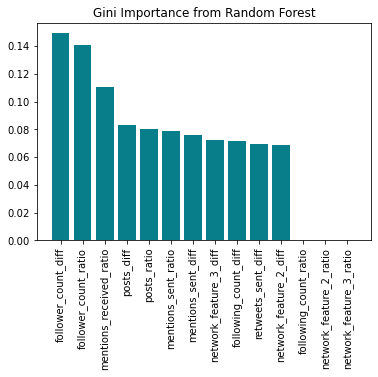

In [12]:
plt.bar(x=feature_importance.index.to_numpy(), height=feature_importance, color='#087E8B')
plt.title("Gini Importance from Random Forest")
plt.xticks(rotation=90)
plt.show()

In [13]:
# refine the random forest model by dropping features that have 0 gini importance
features_selected = list(feature_importance[feature_importance > 0].index)
features_selected

['follower_count_diff',
 'follower_count_ratio',
 'mentions_received_ratio',
 'posts_diff',
 'posts_ratio',
 'mentions_sent_ratio',
 'mentions_sent_diff',
 'network_feature_3_diff',
 'following_count_diff',
 'retweets_sent_diff',
 'network_feature_2_diff']

In [14]:
# best random forest model with selected features
#### this will be the model we choose to use later ####
new_X_train, new_X_test = X_train[features_selected], X_test[features_selected]

clf_rf = RandomForestClassifier(random_state=42).fit(new_X_train, y_train)
y_pred = clf_rf.predict(new_X_test)
y_pred_prob = clf_rf.predict_proba(new_X_test)[:,1]
print("accuracy:", accuracy_score(y_true=y_test, y_pred=y_pred))
print("roc_auc:", roc_auc_score(y_test, y_pred_prob))
confusion_matrix(y_test, y_pred)

accuracy: 0.7518181818181818
roc_auc: 0.835314465408805


array([[408, 122],
       [151, 419]])

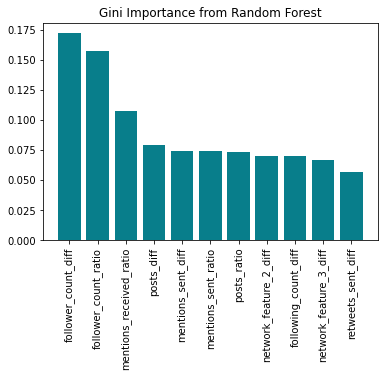

In [15]:
new_feature_importance = pd.Series(clf_rf.feature_importances_, index=new_X_train.columns.to_list()).sort_values(ascending=False)
plt.bar(x=new_feature_importance.index.to_numpy(), height=new_feature_importance, color='#087E8B')
plt.title("Gini Importance from Random Forest")
plt.xticks(rotation=90)
plt.show()

In [16]:
# Logistic Regression
clf2 = LogisticRegression(random_state=42).fit(new_X_train, y_train)
y_pred = clf2.predict(new_X_test)
y_pred_prob = clf2.predict_proba(new_X_test)[:,1]

cm2 = confusion_matrix(y_test, y_pred)
print("accuracy: {}, roc_auc: {}".format(\
                                         accuracy_score(y_true=y_test, y_pred=y_pred), \
                                         roc_auc_score(y_true=y_test, y_score=y_pred_prob)))
cm2

accuracy: 0.6581818181818182, roc_auc: 0.7101456471367097


array([[362, 168],
       [208, 362]])

In [17]:
log_importance = pd.Series(clf2.coef_[0], index=features_selected).sort_values(ascending=False)
log_importance

follower_count_diff        8.343134
mentions_sent_ratio        4.145959
retweets_sent_diff         4.062250
network_feature_2_diff     2.527109
network_feature_3_diff     2.477096
following_count_diff       2.257648
posts_ratio                2.010914
follower_count_ratio       1.070238
mentions_received_ratio    0.855585
mentions_sent_diff         0.851713
posts_diff                 0.778549
dtype: float64

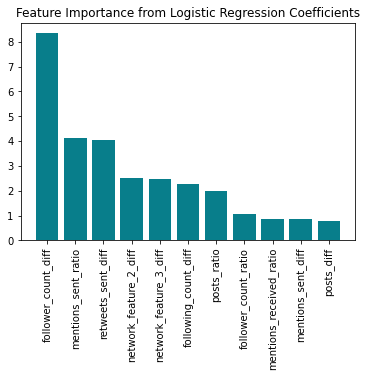

In [18]:
plt.bar(x=log_importance.index.to_numpy(), height=log_importance, color='#087E8B')
plt.title("Feature Importance from Logistic Regression Coefficients")
plt.xticks(rotation=90)
plt.show()

## Part 1.1 answer

Our best model is a Random Forest classifier.
Confusion matrix of our best model:

||0|1|
|---|---|---|
|0|408|122|
|1|151|419|

In our best model (Random Forest), the top 3 best predictors are the difference and ratio of `follower_count`, and the ratio of `mentions_received`.

In our logistic regression model (with an accuracy of 65.8%), the top 3 best predictors are the difference in `follower_count`, ratio of `mentions_sent`, and difference in `retweets_sent`.

The results from two models imply that the absolute value of a user's follwer number is very important in identifying an influencer. If a business would like to optimize their capital in marketing through influencers, they should choose influencers mostly by their follower number and mentions. 

# 1.2 Calculate the financial value of your model
+ non-influencer tweets, no benefit
+ influencer tweets once, 0.01\% chance that followers will buy one unit
+ influencer tweets twice, buying probability 0.015\%

profit margin = \$10 per unit, one customer can buy only one unit 

+ Without analytics, offers \$5 to each person (A and B) to tweet once. 
+ With analytics, offers \$10 to influencers by the model to send two tweets each 
+ non-influencer not selected/paid

What is the lift in expected net profit from using your analytic model (versus not using analytics)? Show all calculations. 

What is the lift in net profit from using a perfect analytic model (versus not using analytics)?

In [19]:
cols = ['Choice','A_follower_count','B_follower_count']
train2 = train.copy()[cols]

In [20]:
### without analytics
# in each observation, 
# cost = $5 * 2 = $10
# if A is influencer, sale = A_follower_count * 10 * 0.01%
# if B is influencer, sale = B_follower_count * 10 * 0.01%

profit_no = float(np.sum(np.where(train2.Choice == 1, \
                                  train2.A_follower_count * 10 * 0.0001 - 5*2, \
                                  train2.B_follower_count * 10 * 0.0001 - 5*2)))
print("profit without analytics: ${:.2f}".format(profit_no))

profit without analytics: $5321568.59


We used the random forest model `clf_rf` in this prediction

In [21]:
### with OUR analysis
# get a predicted column of 'Choice' using our model using both test and train set
new_train = pd.concat([new_X_train, new_X_test],axis=0)
new_train['predicted'] = clf_rf.predict(new_train)

# new_train = pd.concat([X_train, X_test],axis=0)
# new_train['predicted'] = clf1.predict(new_train)

# add the original labels
new_train['actual'] = pd.concat([y_train, y_test], axis=0)

# merge the data above with the original training data and keep only related features
cols = ['actual','predicted','A_follower_count','B_follower_count']
train3 = train2.merge(new_train, left_index=True, right_index=True)[cols]
train3['correct_prediction'] = np.where(train3.actual == train3.predicted, 1, 0)

# train3 will be the table used for this analysis
# cost for each observaiton is 10
# if the prediction is correct, sale = that user's follower count * 10 * 0.015%. Subtract 10 to get profit.
# if the prediction is wrong, sale = 0, profit = -10

# profit from correctly predicted A as the influencer
profit_A = float(np.sum(np.where((train3.correct_prediction == 1) & (train3.predicted == 1), \
                                 train3.A_follower_count*0.00015*10-10, -10)))
# profit from correctly predicted B as the influencer
profit_B = float(np.sum(np.where((train3.correct_prediction == 1) & (train3.predicted == 0), \
                                 train3.B_follower_count*0.00015*10-10, -10)))
profit_model = profit_A + profit_B
lift_model = (profit_model - profit_no)/profit_no
print("profit with our analytics model: ${:.2f}".format(profit_model))
print("Lift: {:.3f} ({:.2%} increase)".format(1+lift_model, lift_model))

profit with our analytics model: $7785920.20
Lift: 1.463 (46.31% increase)


In [22]:
### with PERFECT analytics
# if A is an influencer, profit = A_follower_count * 0.015% * 10 - 10. Same calculation for B
profit_perfect = float(np.sum(np.where(train3.actual == 1, \
                                 train3.A_follower_count*0.00015*10-10, \
                                 train3.B_follower_count*0.00015*10-10)))
lift_perfect = (profit_perfect - profit_no)/profit_no
print("profit with a perfect analytics model: ${:.2f}".format(profit_perfect))
print("Lift: {:.3f} ({:.2%} increase)".format(1+lift_perfect, lift_perfect))

profit with a perfect analytics model: $8009852.89
Lift: 1.505 (50.52% increase)


In [23]:
# analysis on the lift difference
print("A < B even though A has more followers than B:", \
      np.where((train3.actual == 0) & (train3.A_follower_count > train3.B_follower_count), 1, 0).sum())
print("A < B even though A has more followers than B, but model predicts A > B:", \
      np.where((train3.correct_prediction == 0) & (train3.predicted == 1) & (train3.A_follower_count > train3.B_follower_count), 1, 0).sum())

A < B even though A has more followers than B: 656
A < B even though A has more followers than B, but model predicts A > B: 107


If we look deeper into the data, i.e., the `train3` data set, we see that there are many cases where A < B even though A has more followers. And our model wrongly predicted many of these cases. This is because that our model gives a bigger weight to the follower count of each user. But in reality there are lots of other factors determining an influencer. Therefore, in our model, lots of users were identified as an influencer mainly because of its follower counts and this could cause the variation in profit margin calculation.